In [0]:
import nltk

'''
type 'd' for downloading
then type 'all' to download all
'''
nltk.download()

In [0]:
from nltk.corpus import words, stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import email
from os import listdir
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [0]:
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return 'a'
  elif treebank_tag.startswith('V'):
    return 'v'
  elif treebank_tag.startswith('R'):
    return 'r'
  else:
    return 'n' # Return the default
      

def preprocess_text(txt):
  # tokenize and remove special chars
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(txt)
  
  # lowercase
  tokens = [w.lower() for w in tokens]
  
  # remove stopwords
  stop_words = stopwords.words('english')
  tokens = [w for w in tokens if w not in stop_words]
  
  # lemmatizing
  tags = dict(pos_tag(tokens))
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(w, get_wordnet_pos(tags[w])) for w in tokens]


def read_emails(path):
  dirs = listdir(path)
  msg = []

  for file in dirs:
    with open(path + '/' + file, 'rb') as f:        
      msg.append(email.message_from_bytes(f.read()))
  return msg


def get_mail_df(msg_vec, features=['From', 'Subject']):
  df = pd.DataFrame([[val for h, val in mail.items() if h in features] for mail in msg_vec],
                    columns=features)
  df['Body'] = [mail.get_payload() for mail in msg_vec]
  return df

In [0]:
SPAM_PATH = '/gdrive/My Drive/spam'
HAM_PATH = '/gdrive/My Drive/easy_ham'

spam_msg = read_emails(SPAM_PATH)
ham_msg = read_emails(HAM_PATH)
spam_size, ham_size = len(spam_msg), len(ham_msg)
y = np.concatenate([np.ones(spam_size), np.zeros(ham_size)])

df = get_mail_df(spam_msg).append(get_mail_df(ham_msg))
df.head()

From  ...                                               Body
0                             12a1mailbot1@web.de  ...  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1          "Slim n Trim" <yenene@mx2.1premio.com>  ...  I thought you might like these:\n1) Slim Down ...
2             Account Services <wsup@playful.com>  ...  ##############################################...
3  Great Offers <greatoffers@sendgreatoffers.com>  ...  <html>\n<head>\n<title>ReliaQuote - Save Up To...
4          "Slim Down" <taylor@s3.serveimage.com>  ...  1) Fight The Risk of Cancer!\nhttp://www.adcli...

[5 rows x 3 columns]

In [0]:
# clean
df['Body'] = df['Body'].map(lambda text: ' '.join(preprocess_text(str(text))))

In [0]:
# split to train & test
p = np.random.permutation(len(y))
split_size = 0.2
t = int((1 - split_size) * len(p))
train_idx, test_idx = p[:t], p[t:]

X_train, X_test = df.iloc[train_idx, :], df.iloc[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

In [0]:
# data preparation and classification
clf_pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())

params = {'multinomialnb__alpha': np.linspace(1e-10, 5, num=10)}
grid_search = GridSearchCV(clf_pipe, params, cv=3)
grid_search.fit(X_train['Body'], y_train);

In [0]:
grid_search.score(X_test['Body'], y_test)

0.9533333333333334

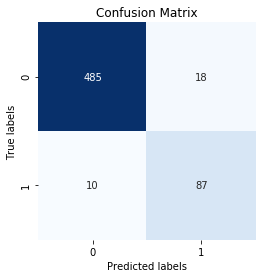

In [5]:
y_pred = grid_search.predict(X_test['Body'])
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, square=True, annot=True, 
            cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

In [7]:
'''
The dataset is imbalanced - spam mails are less than 20%
therefore accuracy alone is not enough.
Better evaluation can be done with precision and recall.
False positive is the "expensive" case, where ham mails are predicted as spam,
so precision is more important.
'''

true_positive = conf_mat[1, 1]
false_positive = conf_mat[0, 1]
false_negative = conf_mat[1, 0]

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
print(f'precision: {precision}, recall: {recall}')

precision: 0.8285714285714286, recall: 0.8969072164948454
